In [39]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

ModuleNotFoundError: No module named 'DateFrame'

In [5]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np

np.random.seed(777)

In [6]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (warning)
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

# 1. 데이터 준비

In [7]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [8]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [9]:
print(train_data)

[[1.23247e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 ... 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.75520e+02
  3.26000e+00]
 ...
 [3.46600e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.62250e+02
  7.83000e+00]
 [2.14918e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.61950e+02
  1.57900e+01]
 [1.43900e-02 6.00000e+01 2.93000e+00 ... 1.56000e+01 3.76700e+02
  4.38000e+00]]


In [10]:
print(train_targets) # 단위: 천 달러

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

# 2. 데이터 전처리

In [11]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)                          #표준편차
train_data /= std

#!!!!!!!!!!!***** 테스트 셋도 훈련 셋에서 계산된 mean과 std를 동일하게 사용함     ****!!!!!!!!!!!!!!!!!1
#!!!!!!!!!!! ****만약 각각 정규화를 수행해버리면, 학습 결과 적용이 불가능해짐   **** !!!!!!!!!!!!!!!!!!!!!!
test_data -= mean
test_data /= std

In [12]:
print(test_data)

[[ 1.55369355 -0.48361547  1.0283258  ...  0.78447637 -3.48459553
   2.25092074]
 [-0.39242675 -0.48361547 -0.16087773 ... -0.30759583  0.42733126
   0.47880119]
 [-0.39982927 -0.48361547 -0.86940196 ...  0.78447637  0.44807713
  -0.41415936]
 ...
 [-0.20709507 -0.48361547  1.24588095 ... -1.71818909  0.37051949
  -1.49344089]
 [-0.36698601 -0.48361547 -0.72093526 ... -0.48960787  0.39275481
  -0.41829982]
 [-0.0889679  -0.48361547  1.24588095 ... -1.71818909 -1.21946544
  -0.40449827]]


# 3. 네트워크 정의

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1)) # 회귀 모델 (출력층에 활성화 함수 없음) 구하고자 하는 값이 1개 여서
                        
     
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])   # mae= 실제값과 예상치의 차이의 절대값
    
    return model

# 4. (K-겹 교차 검증을 사용한) 모델 학습

In [14]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):                                   # k겹으로 나누기
    print('>> fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]            #train_data[0:100]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                           axis=0)

    model = build_model()
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)                    # verbose= 0 : 값 일일이 보여주기(off)             
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)          # loss / matrics 에 넣은
                                                                                 #      값 분리해서 넣어줌
    all_scores.append(val_mae)

print('finished!!')

>> fold  0
>> fold  1
>> fold  2
>> fold  3
finished!!


In [15]:
#print(val_mae)

In [25]:
print(all_scores)
mean = np.mean(all_scores)
stddev = np.std(all_scores)

print(u'%.2f \u00B1(%.2f)'%(mean, stddev))

[2.2933137, 2.7139206, 2.6138644, 2.208067]
2.46 ±(0.21)


In [26]:
'''
4-fold의 평균 validation MAE 그래프 그리기
'''

print(model.metrics_names)

['loss', 'mean_absolute_error']


In [24]:
#오버피팅 지점을 확인하고 수정하고자 함
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('>> fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    hist = model.fit(partial_train_data, 
                     partial_train_targets,
                     epochs = num_epochs,
                     batch_size = 1,
                     verbose = 0,
                     validation_data = (val_data, val_targets))           #오버피팅 확인
    
    mae_history = hist.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
print('finished!!')

>> fold  0
>> fold  1
>> fold  2
>> fold  3
finished!!


In [45]:
import pandas as pd
print(np.shape(all_mae_histories))


(4, 500)


In [28]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print(average_mae_history)

[4.412855, 3.35191, 3.1855044, 2.7467566, 2.7155178, 2.7543688, 2.5986161, 2.7603445, 2.5734055, 2.4897516, 2.5934386, 2.5240877, 2.529097, 2.6500962, 2.50016, 2.5041437, 2.380199, 2.4454672, 2.5277271, 2.5924363, 2.4526134, 2.4181392, 2.4570441, 2.464826, 2.3474817, 2.4776862, 2.411089, 2.4052217, 2.4991245, 2.487019, 2.4004865, 2.428668, 2.3640292, 2.4439094, 2.4178889, 2.3544185, 2.3141482, 2.4124057, 2.3007495, 2.546064, 2.3366225, 2.5828378, 2.3416624, 2.3222516, 2.3484511, 2.4995756, 2.3520336, 2.5477817, 2.3781395, 2.3709307, 2.3746982, 2.3491857, 2.3857117, 2.4477746, 2.3451922, 2.4203799, 2.3988676, 2.3156266, 2.437033, 2.4669816, 2.3853228, 2.3883317, 2.3318677, 2.3798132, 2.3988123, 2.4769273, 2.6613348, 2.7065587, 2.4683888, 2.4280567, 2.3349147, 2.4306824, 2.5739706, 2.5843668, 2.4261208, 2.5926294, 2.3533938, 2.4218411, 2.4868193, 2.4645698, 2.6444051, 2.46426, 2.4852095, 2.5355823, 2.48296, 2.4730647, 2.5779614, 2.467443, 2.5958786, 2.3538797, 2.537199, 2.555273, 2.40825

average_mae_history = []
for epoch in range(num_epochs):
    average_mae_per_epoch = []
    
    for mae_history in all_mae_histories: # 4개 fold 반복
        average_mae_per_epoch.append(mae_history[epoch])
    
    mean = np.mean(average_mae_per_epoch)
    average_mae_history.append(mean)

print(average_mae_history)

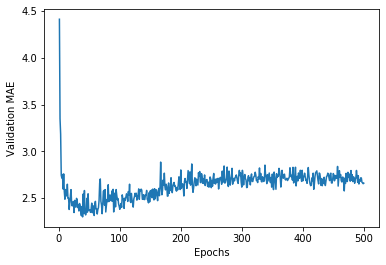

In [29]:
import matplotlib.pyplot as plt

# matplotlib이 Jupyter notebook 셀 안에서 생성되도록 함
# https://versusall.tistory.com/entry/Jupyter-Notebook-4-%EC%99%B8%EB%B6%80%EC%B0%BD%EC%97%90%EC%84%9C-%EA%B7%B8%EB%9E%98%ED%94%84-%EA%B7%B8%EB%A6%AC%EA%B8%B0-matplotlib-inline-qt-tk%C2%B6
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

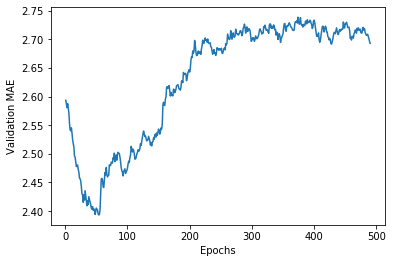

In [30]:
'''
시계열 신호에 지수 이동 평균(exponential moving averge) 필터링
'''
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 5. (과대적합 되기 전까지) 모델 학습

In [31]:
# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = build_model()
model.fit(train_data, 
          train_targets,
          epochs = 80,
          batch_size = 16,
          verbose = 1)

Epoch 1/80
404/404 [==============================] - 0s 610us/sample - loss: 506.2232 - mean_absolute_error: 20.5716
Epoch 2/80
404/404 [==============================] - 0s 178us/sample - loss: 327.6340 - mean_absolute_error: 15.9744
Epoch 3/80
404/404 [==============================] - 0s 178us/sample - loss: 155.9570 - mean_absolute_error: 10.1047
Epoch 4/80
404/404 [==============================] - 0s 178us/sample - loss: 68.0666 - mean_absolute_error: 6.1272
Epoch 5/80
404/404 [==============================] - 0s 173us/sample - loss: 40.8779 - mean_absolute_error: 4.8338
Epoch 6/80
404/404 [==============================] - 0s 180us/sample - loss: 29.5189 - mean_absolute_error: 4.0324
Epoch 7/80
404/404 [==============================] - 0s 183us/sample - loss: 23.8634 - mean_absolute_error: 3.5621
Epoch 8/80
404/404 [==============================] - 0s 180us/sample - loss: 20.4303 - mean_absolute_error: 3.1928
Epoch 9/80
404/404 [==============================] - 0s 178us/sam

404/404 [==============================] - 0s 173us/sample - loss: 6.7895 - mean_absolute_error: 1.8208
Epoch 72/80
404/404 [==============================] - 0s 173us/sample - loss: 7.0428 - mean_absolute_error: 1.8351
Epoch 73/80
404/404 [==============================] - 0s 180us/sample - loss: 6.7737 - mean_absolute_error: 1.8248
Epoch 74/80
404/404 [==============================] - 0s 178us/sample - loss: 6.6457 - mean_absolute_error: 1.8039
Epoch 75/80
404/404 [==============================] - 0s 180us/sample - loss: 6.7511 - mean_absolute_error: 1.8122
Epoch 76/80
404/404 [==============================] - 0s 163us/sample - loss: 6.4959 - mean_absolute_error: 1.7833
Epoch 77/80
404/404 [==============================] - 0s 165us/sample - loss: 6.5268 - mean_absolute_error: 1.7910
Epoch 78/80
404/404 [==============================] - 0s 170us/sample - loss: 6.4937 - mean_absolute_error: 1.7555
Epoch 79/80
404/404 [==============================] - 0s 163us/sample - loss: 6.482

# 6. 테스트셋으로 성능 평가하기

In [19]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('test MSE score: %.3f', test_mse_score)
print('test MAE score: %.3f', test_mae_score)

102/102 [==============================] - 0s 978us/sample - loss: 17.6753 - mean_absolute_error: 2.7005
test MSE score: %.3f 17.675254821777344
test MAE score: %.3f 2.7004523
